In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from tqdm import tqdm
import joblib
from skimage.feature import hog


In [2]:
plt.style.use('ggplot')

projectRoot = Path().resolve().parent
datasetPath = projectRoot / "CV2024_CW_Dataset"
outputRoot = projectRoot / "ModifiedDataset"

trainOutputPath = outputRoot / "train" / "images"
trainOutputLabelPath = outputRoot / "train" / "labels"
testOutputPath = outputRoot / "test" / "images"
testOutputLabelPath = outputRoot / "test" / "labels"
valOutputPath = outputRoot / "validation" / "images"
valOutputLabelPath = outputRoot / "validation" / "labels"

# features directory
featuresDir = outputRoot / "features"
featuresDir.mkdir(parents=True, exist_ok=True)

for path in [trainOutputPath, trainOutputLabelPath, testOutputPath, testOutputLabelPath, valOutputPath, valOutputLabelPath]:
    if not path.exists():
        print(f"Warning: Path {path} does not exist")

print("Paths set up successfully.")

Paths set up successfully.


In [3]:
def extract_dataset_features(image_paths, label_paths, hog_params=None):
    if hog_params is None:
        hog_params = {
            'orientations': 9,
            'pixels_per_cell': (8, 8),
            'cells_per_block': (2, 2)
        }
    
    features = []
    labels = []
    
    #extract features/labels
    for img_path, label_path in tqdm(zip(image_paths, label_paths), total=len(image_paths), desc="Extracting HOG features"):
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        with open(label_path, 'r') as f:
            label = int(f.read().strip())
        
        # extract HOG features
        hog_features = compute_hog_features(
            image,
            orientations=hog_params['orientations'],
            pixels_per_cell=hog_params['pixels_per_cell'],
            cells_per_block=hog_params['cells_per_block']
        )
        
        features.append(hog_features)
        labels.append(label)
    
    return np.array(features), np.array(labels)

In [4]:
def prepare_dataset_features(dataset_path, output_path, dataset_type, hog_params=None):
    #define paths
    images_path = os.path.join(dataset_path, dataset_type, "images")
    labels_path = os.path.join(dataset_path, dataset_type, "labels")
    
    # get all image files
    image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.jpeg')])
    
    image_paths = [os.path.join(images_path, f) for f in image_files]
    label_paths = [os.path.join(labels_path, f.replace('.jpeg', '.txt')) for f in image_files]
    
    X, y = extract_dataset_features(image_paths, label_paths, hog_params)
    
    os.makedirs(output_path, exist_ok=True)
    
    # Save features/labels
    joblib.dump((X, y), os.path.join(output_path, f"{dataset_type}_hog_features.joblib"))
    
    print(f"Saved {dataset_type} HOG features with shape {X.shape}")
    return X, y

In [5]:
def visualize_hog_features(image_path, hog_params=None):
    if hog_params is None:
        hog_params = {
            'orientations': 9,
            'pixels_per_cell': (8, 8),
            'cells_per_block': (2, 2)
        }
    
    # Read image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize pixel values
    if image.max() > 1:
        image_normalized = image / 255.0
    else:
        image_normalized = image.copy()
    
    # Extract HOG features with visualization
    hog_features, hog_image = compute_hog_features(
        image_normalized,
        orientations=hog_params['orientations'],
        pixels_per_cell=hog_params['pixels_per_cell'],
        cells_per_block=hog_params['cells_per_block'],
        visualize=True
    )
    
    return image, hog_image

In [6]:
def optimize_hog_parameters(sample_images, sample_labels, param_grid):
    from sklearn.model_selection import GridSearchCV
    from sklearn.svm import SVC
    
    # define parameter grid
    orientations = param_grid.get('orientations', [9])
    pixels_per_cells = param_grid.get('pixels_per_cell', [(8, 8)])
    cells_per_blocks = param_grid.get('cells_per_block', [(2, 2)])
    
    # store results
    results = []
    
    total_combinations = len(orientations) * len(pixels_per_cells) * len(cells_per_blocks)
    pbar = tqdm(total=total_combinations, desc="Optimizing HOG parameters")
    
    for orientation in orientations:
        for pixels_per_cell in pixels_per_cells:
            for cells_per_block in cells_per_blocks:
                hog_params = {
                    'orientations': orientation,
                    'pixels_per_cell': pixels_per_cell,
                    'cells_per_block': cells_per_block
                }
                
                # extract features for samples
                sample_features = []
                for img_path in sample_images:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    features = compute_hog_features(img, **hog_params)
                    sample_features.append(features)
                
                # Train a simple SVM
                svm = SVC(kernel='linear')
                svm.fit(sample_features, sample_labels)
                score = svm.score(sample_features, sample_labels)
                
                # Store results
                results.append({
                    'params': hog_params,
                    'score': score,
                    'feature_dim': len(sample_features[0])
                })
                
                pbar.update(1)
    
    pbar.close()
    
    # find best parameters
    results.sort(key=lambda x: x['score'], reverse=True)
    best_params = results[0]['params']
    
    print(f"Best HOG parameters: {best_params} with score {results[0]['score']:.4f}")
    print(f"Feature dimension: {results[0]['feature_dim']}")
    
    return best_params

In [7]:
def display_sample_hog_features(image_paths, hog_params=None, num_samples=3):
    import random
    
    # get random samples
    if len(image_paths) > num_samples:
        sample_paths = random.sample(image_paths, num_samples)
    else:
        sample_paths = image_paths
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))
    
    for i, img_path in enumerate(sample_paths):
        # get original image and HOG visualization
        original, hog_img = visualize_hog_features(img_path, hog_params)
        
        #display original image
        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title(f"Original Image")
        axes[i, 0].axis('off')
        
        # display HOG features
        axes[i, 1].imshow(hog_img, cmap='gray')
        axes[i, 1].set_title(f"HOG Features")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [8]:
#feature extraction parameters
hog_params = {
    'orientations': 9,        
    'pixels_per_cell': (8, 8), 
    'cells_per_block': (2, 2)  
}

features_dir = outputRoot / "features"
features_dir.mkdir(parents=True, exist_ok=True)

print("Extracting HOG features from datasets...")

# Training set
X_train, y_train = prepare_dataset_features(
    str(outputRoot),
    str(features_dir),
    "train",
    hog_params=hog_params
)

# Validation set
X_val, y_val = prepare_dataset_features(
    str(outputRoot),
    str(features_dir),
    "validation",
    hog_params=hog_params
)

# Test set
X_test, y_test = prepare_dataset_features(
    str(outputRoot),
    str(features_dir),
    "test",
    hog_params=hog_params
)

print("HOG feature extraction complete!")
print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Test features shape: {X_test.shape}")

Extracting HOG features from datasets...


Extracting HOG features:   0%|                                                                                                                                | 0/1916 [00:00<?, ?it/s]


NameError: name 'compute_hog_features' is not defined

Displaying HOG features for sample images...


NameError: name 'compute_hog_features' is not defined

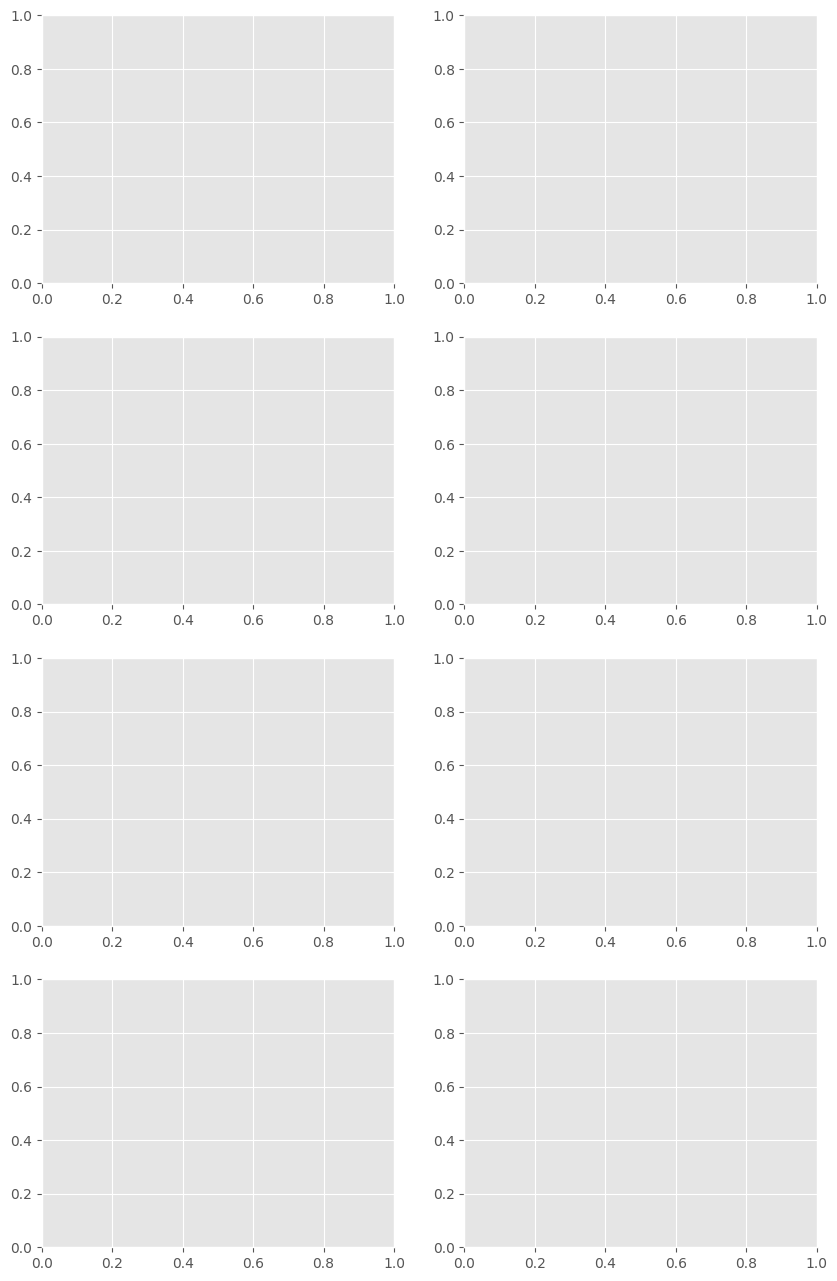

In [9]:
# Visualize HOG features 
print("Displaying HOG features for sample images...")

# path to some training imgs
train_image_dir = str(trainOutputPath)
train_image_files = sorted([f for f in os.listdir(train_image_dir) if f.endswith('.jpeg')])
train_image_paths = [os.path.join(train_image_dir, f) for f in train_image_files]

# display HOG features for sample imgs
display_sample_hog_features(train_image_paths, hog_params, num_samples=4)